In [1]:
#!pip3 install bayesian-optimization==0.6 --user
#!pip3 install pip install bayesian-optimization --user
!pip3 install git+https://github.com/fmfn/BayesianOptimization

  Cloning https://github.com/fmfn/BayesianOptimization to c:\users\cyberpower pc\appdata\local\temp\pip-req-build-pq4nkj5k
  Resolved https://github.com/fmfn/BayesianOptimization to commit 8ed5a3767634e5f47d0e3bf02b2dc11a6d241527
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/fmfn/BayesianOptimization 'C:\Users\Cyberpower PC\AppData\Local\Temp\pip-req-build-pq4nkj5k'


I use `bayesian-optimization==0.6`, my backend pretty much stick with this version, so migrating will break the code.

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()
%matplotlib inline

In [3]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

matplotlib==3.6.2
numpy==1.23.4
pandas==1.5.1
seaborn==0.12.1


In [4]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [5]:
df = pd.read_csv('.\\Data\GME.csv')
display(df.head())
display(df.tail())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,4.7500,4.7750,4.2875,4.3125,4.3125,40090000
1,2021-01-05,4.3375,4.5200,4.3075,4.3425,4.3425,19846000
2,2021-01-06,4.3350,4.7450,4.3325,4.5900,4.5900,24224800
3,2021-01-07,4.6175,4.8625,4.5050,4.5200,4.5200,24517200
4,2021-01-08,4.5450,4.5750,4.2700,4.4225,4.4225,25928000


,Date,Open,High,Low,Close,Adj Close,Volume
460,2022-10-31,31.219999,34.990002,27.910000,28.309999,28.309999,24027600
461,2022-11-01,29.400000,29.690001,27.620001,28.389999,28.389999,5147500
462,2022-11-02,27.900000,28.750000,26.500000,26.620001,26.620001,4143900
463,2022-11-03,26.000000,27.290001,26.000000,26.290001,26.290001,3384400
464,2022-11-04,26.600000,27.030001,25.340000,26.510000,26.510000,4133700


In [6]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [7]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [8]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [9]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        1000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(100, 110)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [10]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [11]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 90),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.00001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 170, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Search parameters {'window_size': 22, 'skip': 14, 'population_size': 16, 'sigma': 0.9727626072874381, 'learning_rate': 0.1739464204150389, 'size_network': 217}
time taken to train: 1.375514268875122 seconds
stop after 100 iteration with investment 43.522749
| 1         | 43.52     | 0.1739    | 16.33     | 0.9728    | 216.8     | 13.69     | 22.42     |

Search parameters {'window_size': 38, 'skip': 11, 'population_size': 90, 'sigma': 0.33734346276920557, 'learning_rate': 0.013370677928857499, 'size_network': 812}
time taken to train: 64.92516541481018 seconds
stop after 100 iteration with investment 43.003750
| 2         | 43.0      | 0.01337   | 89.51     | 0.3373    | 811.6     | 10.51     | 37.72     |

Search parameters {'window_size': 22, 'skip': 4, 'population_size': 89, 'sigma': 0.035

C:\Users\Cyberpower PC\AppData\Local\Temp\ipykernel_11804\1667285525.py:39: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
| 3         | 0.0       | 0.4127    | 88.78     | 0.0351    | 13.98     | 4.324     | 21.99     |

Search parameters {'window_size': 48, 'skip': 11, 'population_size': 48, 'sigma': 0.8321407784672594, 'learning_rate': 0.016727110408676298, 'size_network': 150}
time taken to train: 5.116855144500732 seconds
stop after 100 iteration with investment 8.217500
| 4         | 8.218     | 0.01673   | 47.64     | 0.8321    | 150.4     | 10.96     | 48.1      |

Search parameters {'window_size': 46, 'skip': 5, 'population_size': 82, 'sigma': 0.010621776969125321, 'learning_rate': 0.1353077167469699, 'size_network': 870}
stop after 100 iteration with investment 0.000000
| 5         | 0.0       | 0.1353    | 81.95     | 0.01062   | 870.3     | 5.469     | 46.04     |

Search parameters {'window_size': 2, 'skip': 10, 'population_size': 19, 'sigma': 0.5803796634227105, 'learning_rate': 0.32555555043056467, 'size_network': 107}
time taken to train: 1.

C:\Users\Cyberpower PC\AppData\Local\Temp\ipykernel_11804\1667285525.py:39: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
| 35        | 0.0       | 0.49      | 10.95     | 0.03593   | 458.3     | 7.466     | 15.89     |

Search parameters {'window_size': 10, 'skip': 4, 'population_size': 71, 'sigma': 0.9588105258310954, 'learning_rate': 0.28005591397498886, 'size_network': 22}
time taken to train: 8.641743659973145 seconds
stop after 100 iteration with investment 144.270000
| 36        | 144.3     | 0.2801    | 71.07     | 0.9588    | 22.2      | 3.755     | 10.4      |

Search parameters {'window_size': 7, 'skip': 11, 'population_size': 18, 'sigma': 0.586581479292507, 'learning_rate': 0.11309199688293264, 'size_network': 664}
time taken to train: 1.288640022277832 seconds
stop after 100 iteration with investment 67.861247
| 37        | 67.86     | 0.1131    | 18.21     | 0.5866    | 663.7     | 10.79     | 7.059     |

Search parameters {'window_size': 41, 'skip': 9, 'population_size': 65, 'sigma': 0.2731058573640203, 'learning_rate': 0.13792538427375445,

C:\Users\Cyberpower PC\AppData\Local\Temp\ipykernel_11804\1667285525.py:39: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
| 56        | 0.0       | 0.4238    | 30.59     | 0.03321   | 275.2     | 9.084     | 14.25     |

Search parameters {'window_size': 30, 'skip': 2, 'population_size': 61, 'sigma': 0.6687732390432959, 'learning_rate': 0.04717239740717304, 'size_network': 801}
time taken to train: 198.17032146453857 seconds
stop after 100 iteration with investment 93.962000
| 57        | 93.96     | 0.04717   | 61.38     | 0.6688    | 801.4     | 2.194     | 30.39     |

Search parameters {'window_size': 10, 'skip': 8, 'population_size': 44, 'sigma': 0.3125533440269337, 'learning_rate': 0.0038878930300530017, 'size_network': 458}
time taken to train: 3.8990819454193115 seconds
stop after 100 iteration with investment 56.493507
| 58        | 56.49     | 0.003888  | 44.17     | 0.3126    | 457.6     | 7.949     | 9.98      |

Search parameters {'window_size': 20, 'skip': 14, 'population_size': 40, 'sigma': 0.9386132935718506, 'learning_rate': 0.251888879214

C:\Users\Cyberpower PC\AppData\Local\Temp\ipykernel_11804\1667285525.py:39: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
| 60        | 0.0       | 0.06977   | 72.93     | 0.06299   | 95.77     | 6.151     | 8.729     |

Search parameters {'window_size': 19, 'skip': 1, 'population_size': 71, 'sigma': 0.46336293908261056, 'learning_rate': 0.23874606104958895, 'size_network': 321}
time taken to train: 42.537718534469604 seconds
stop after 100 iteration with investment 518.874504
| 61        | 518.9     | 0.2387    | 71.3      | 0.4634    | 321.3     | 1.167     | 19.09     |

Search parameters {'window_size': 28, 'skip': 3, 'population_size': 28, 'sigma': 0.728091910974412, 'learning_rate': 0.3475235788901307, 'size_network': 917}
time taken to train: 61.16835641860962 seconds
stop after 100 iteration with investment 224.406246
| 62        | 224.4     | 0.3475    | 28.21     | 0.7281    | 917.0     | 3.256     | 27.66     |

Search parameters {'window_size': 9, 'skip': 3, 'population_size': 5, 'sigma': 0.9280613957046734, 'learning_rate': 0.03752651414204592

C:\Users\Cyberpower PC\AppData\Local\Temp\ipykernel_11804\1667285525.py:39: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
| 106       | 0.0       | 0.232     | 57.76     | 0.01      | 652.3     | 1.024     | 44.02     |

Search parameters {'window_size': 45, 'skip': 2, 'population_size': 64, 'sigma': 0.6924540116862193, 'learning_rate': 0.4378518759834595, 'size_network': 643}
time taken to train: 212.65266871452332 seconds
stop after 100 iteration with investment 490.120495
| 107       | 490.1     | 0.4379    | 63.5      | 0.6925    | 643.1     | 2.225     | 44.55     |

Search parameters {'window_size': 14, 'skip': 2, 'population_size': 66, 'sigma': 0.31719481928365206, 'learning_rate': 0.31997291791301896, 'size_network': 321}
time taken to train: 18.831195831298828 seconds
stop after 100 iteration with investment 412.718491
| 108       | 412.7     | 0.32      | 65.76     | 0.3172    | 321.4     | 1.528     | 14.43     |

Search parameters {'window_size': 44, 'skip': 2, 'population_size': 57, 'sigma': 0.8472817212451614, 'learning_rate': 0.0894231765266

C:\Users\Cyberpower PC\AppData\Local\Temp\ipykernel_11804\1667285525.py:39: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
| 192       | 0.0       | 0.4614    | 82.28     | 0.0491    | 701.6     | 6.222     | 28.94     |

Search parameters {'window_size': 16, 'skip': 2, 'population_size': 64, 'sigma': 0.02796613906177025, 'learning_rate': 0.20992444463035906, 'size_network': 320}


C:\Users\Cyberpower PC\AppData\Local\Temp\ipykernel_11804\1667285525.py:39: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
| 193       | 0.0       | 0.2099    | 64.11     | 0.02797   | 320.2     | 1.768     | 15.78     |

Search parameters {'window_size': 36, 'skip': 2, 'population_size': 11, 'sigma': 0.49118595024269335, 'learning_rate': 0.1355391820283742, 'size_network': 85}
time taken to train: 3.6278040409088135 seconds
stop after 100 iteration with investment 366.011245
| 194       | 366.0     | 0.1355    | 10.96     | 0.4912    | 85.24     | 1.741     | 36.2      |

Search parameters {'window_size': 21, 'skip': 2, 'population_size': 71, 'sigma': 0.4496458385359687, 'learning_rate': 0.25100224418689926, 'size_network': 313}
time taken to train: 22.479933500289917 seconds
stop after 100 iteration with investment 392.469752
| 195       | 392.5     | 0.251     | 70.64     | 0.4496    | 312.9     | 2.08      | 21.31     |

Search parameters {'window_size': 45, 'skip': 1, 'population_size': 54, 'sigma': 0.2811932355746744, 'learning_rate': 0.20760390669888

In [12]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.max['target'])
print('Best AGENT parameters: ', NN_BAYESIAN.max['params'])
%matplotlib inline

Best AGENT accuracy value: 698.666244
Best AGENT parameters:  {'learning_rate': 0.287376193260779, 'population_size': 85.38952602372164, 'sigma': 0.22609652813829437, 'size_network': 695.5733189825535, 'skip': 1.3870273671208688, 'window_size': 24.88505443533264}


#### My selected parameters

In [13]:
best_agent(
    window_size = 30, 
    skip = 1, 
    population_size = 15, 
    sigma = 0.1, 
    learning_rate = 0.03, 
    size_network = 500
)

time taken to train: 97.4141857624054 seconds


610.3515056999998

#### bayesian parameters

In [14]:
best_agent(
    window_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])), 
    skip = int(np.around(NN_BAYESIAN.max['params']['skip'])), 
    population_size = int(np.around(NN_BAYESIAN.max['params']['population_size'])), 
    sigma = NN_BAYESIAN.max['params']['sigma'], 
    learning_rate = NN_BAYESIAN.max['params']['learning_rate'], 
    size_network = int(np.around(NN_BAYESIAN.max['params']['size_network']))
)

time taken to train: 546.6328675746918 seconds


737.3624977999999

#### My selected parameters

iter 100. reward: 469.458988
iter 200. reward: 564.426503
iter 300. reward: 624.290501
iter 400. reward: 656.385246
iter 500. reward: 667.635501
time taken to train: 470.13625979423523 seconds
day 17: buy 1 units at price 48.400002, total balance 951.599998
day 18, sell 1 units at price 81.250000, investment 67.871894 %, total balance 1032.849998,
day 22: buy 5 units at price 66.875000, total balance 965.974998
day 24: buy 5 units at price 75.000000, total balance 890.974998
day 25: buy 5 units at price 62.887500, total balance 828.087498
day 26: buy 5 units at price 64.000000, total balance 764.087498
day 27: buy 5 units at price 63.875000, total balance 700.212498
day 29: buy 5 units at price 61.887500, total balance 638.324998
day 32: buy 5 units at price 50.737500, total balance 587.587498
day 34: buy 1 units at price 11.242500, total balance 576.344998
day 35: buy 5 units at price 114.637500, total balance 461.707498
day 37: buy 5 units at price 127.174995, total balance 334.53250

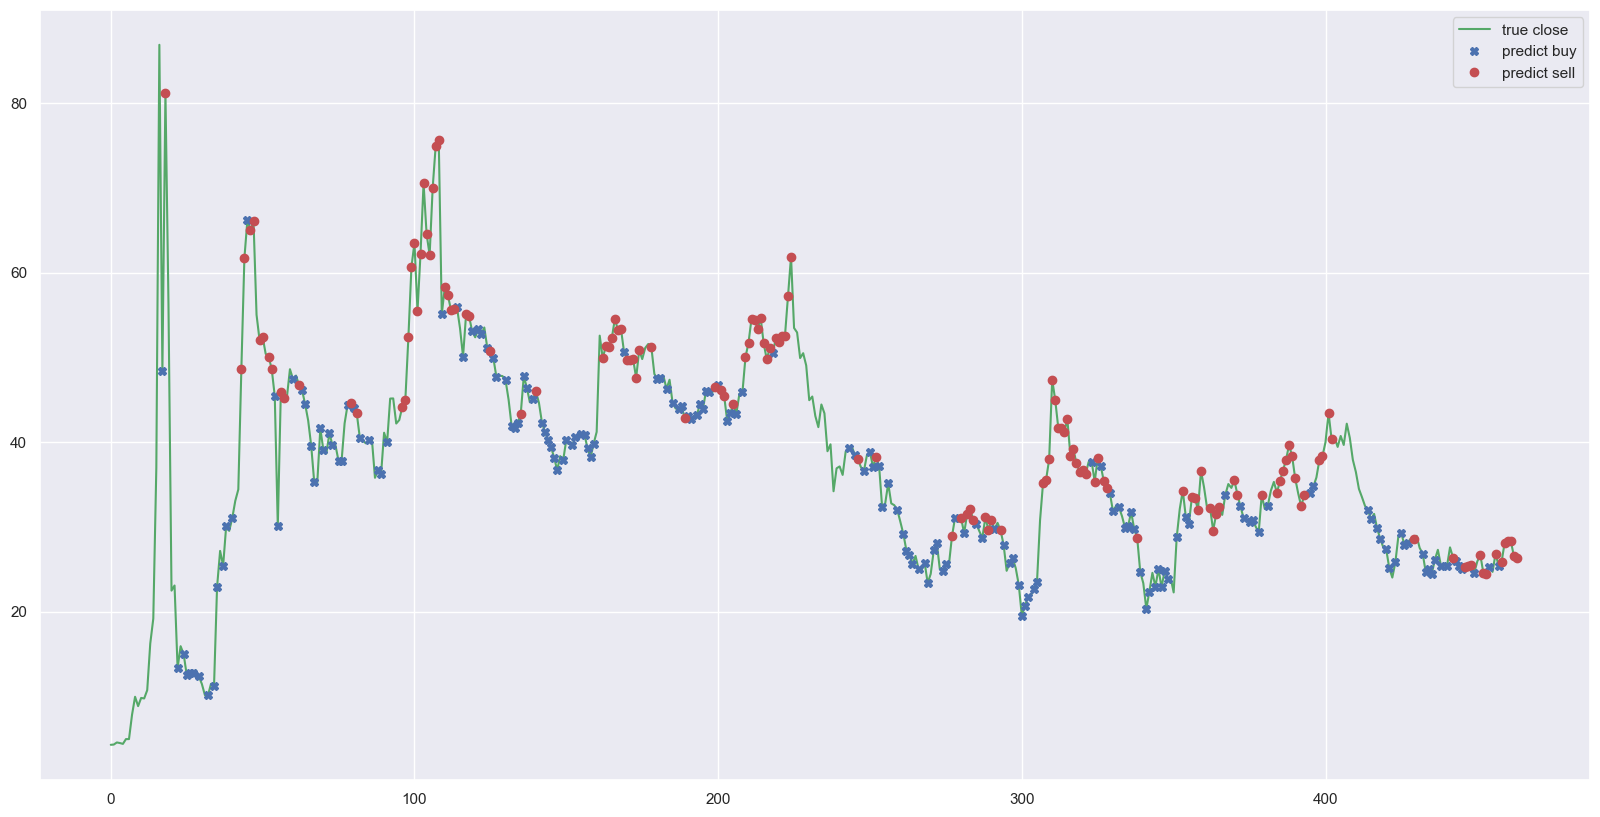

In [15]:
model = Model(input_size = 30, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              model = model, 
              money = 1000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = 1, 
              window_size = 30)
agent.fit(500, 100)
agent.buy()

#### bayesian parameters

iter 100. reward: 598.692490
iter 200. reward: 726.650995
iter 300. reward: 777.669243
iter 400. reward: 772.376998
iter 500. reward: 806.955248
time taken to train: 2725.0452539920807 seconds
day 0: buy 5 units at price 21.562500, total balance 978.437500
day 1: buy 5 units at price 21.712500, total balance 956.725000
day 2: buy 5 units at price 22.950000, total balance 933.775000
day 3: buy 5 units at price 22.600000, total balance 911.175000
day 4: buy 5 units at price 22.112500, total balance 889.062500
day 5: buy 5 units at price 24.925000, total balance 864.137500
day 6: buy 5 units at price 24.937500, total balance 839.200000
day 7: buy 5 units at price 39.250000, total balance 799.950000
day 8: buy 5 units at price 49.887500, total balance 750.062500
day 9: buy 5 units at price 44.375000, total balance 705.687500
day 10, sell 5 units at price 49.200000, investment 128.173913 %, total balance 754.887500,
day 12: buy 5 units at price 53.787500, total balance 701.100000
day 14: bu

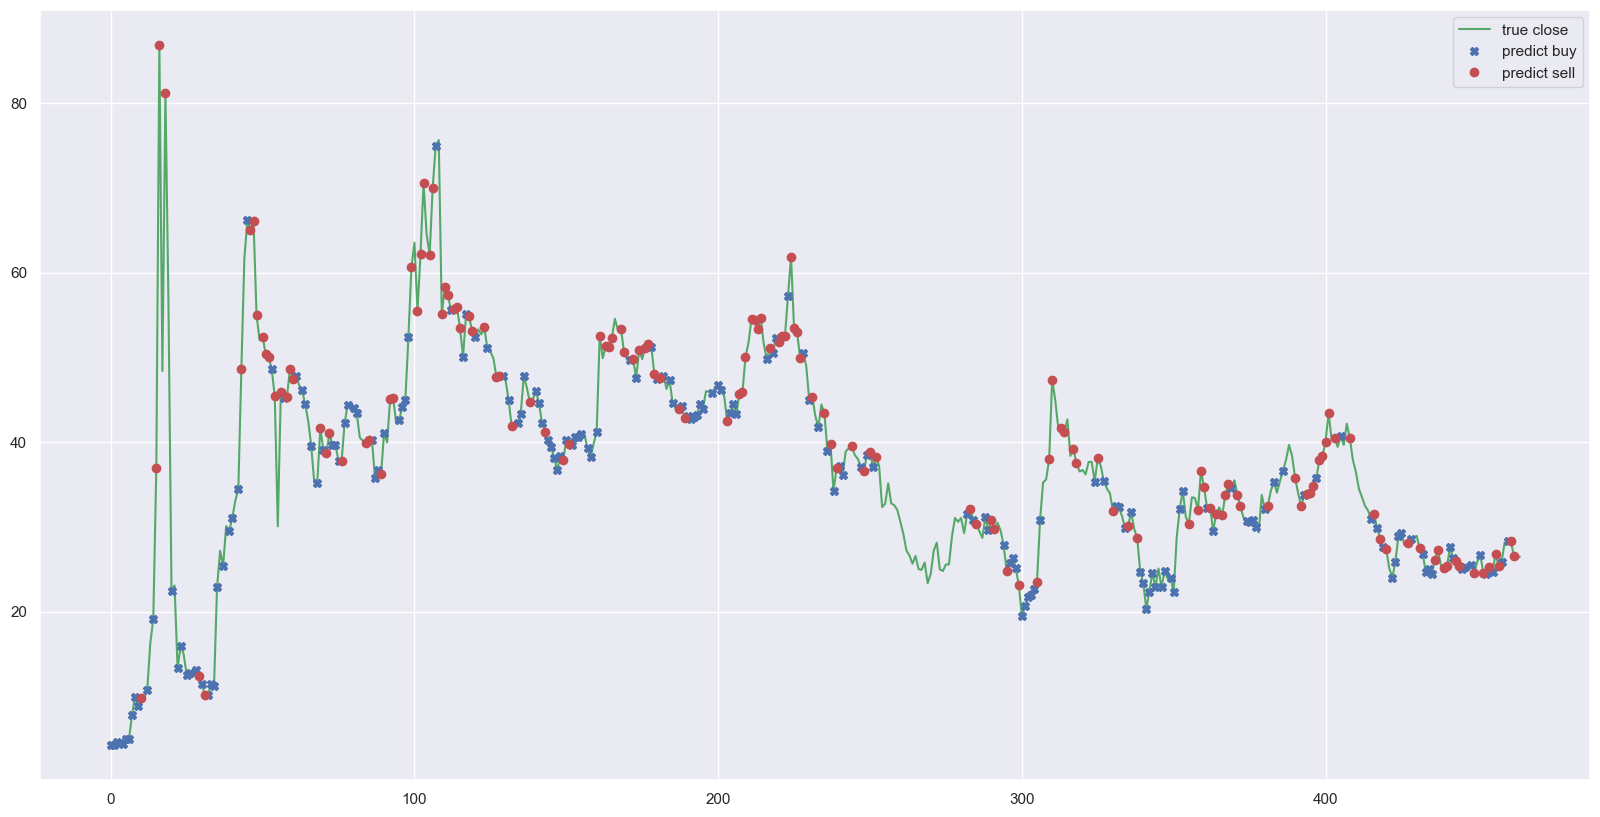

In [16]:
model = Model(input_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])), 
              layer_size = int(np.around(NN_BAYESIAN.max['params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.max['params']['population_size'])), 
              sigma = NN_BAYESIAN.max['params']['sigma'], 
              learning_rate = NN_BAYESIAN.max['params']['learning_rate'], 
              model = model, 
              money = 1000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = int(np.around(NN_BAYESIAN.max['params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])))
agent.fit(500, 100)
agent.buy()



In [17]:
from datetime import datetime
print(datetime.now())

2022-11-16 15:34:23.529189
